In [2]:
import sys
import warnings

from pathlib import Path
from addict import Dict

sys.path.append('../../')
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit

from examples.utils.config import Config
from examples.utils.dataset_adapters import retina_dataset
from spikebench import TrainNormalizeTransform, TsfreshVectorizeTransform, TsfreshFeaturePreprocessorPipeline
from spikebench.utils import simple_undersampling
from spikebench.mpladeq import prettify, beautify_mpl, boxplot

beautify_mpl()

In [18]:
config_dict = {
    'seed': 0,
    'window': 200,
    'step': 200,
    'scale': True,
    'remove_low_variance': True,
    'train_subsample_factor': 0.7,
    'test_subsample_factor': 0.7,
    'delimiter': None,
    'feature_set': 'full',
    'dataset': '../../data/retina/mode_paper_data',
    'n_trees': 200,
    'fstate': 'randomly_moving_bar',
    'mstate': 'white_noise_checkerboard',
}

config = Config(config_dict)
np.random.seed(config.seed)

In [19]:
retinal_spike_data = retina_dataset(config.dataset)

In [20]:
group_split = GroupShuffleSplit(n_splits=1, test_size=0.5)
X = np.hstack(
    [
        retinal_spike_data[config.fstate].series.values,
        retinal_spike_data[config.mstate].series.values,
    ]
)
y = np.hstack(
    [
        np.ones(retinal_spike_data[config.fstate].shape[0]),
        np.zeros(retinal_spike_data[config.mstate].shape[0]),
    ]
)
groups = np.hstack(
    [
        retinal_spike_data[config.fstate].groups.values,
        retinal_spike_data[config.mstate].groups.values,
    ]
)

In [21]:
for train_index, test_index in group_split.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

X_train = pd.DataFrame({'series': X_train, 'groups': groups[train_index]})
X_test = pd.DataFrame({'series': X_test, 'groups': groups[test_index]})

In [22]:
normalizer = TrainNormalizeTransform(
    window=config.window, 
    step=config.step, 
    n_samples=None
)
X_train, y_train = normalizer.transform(X_train, y_train, delimiter=config.delimiter)
X_test, y_test = normalizer.transform(X_test, y_test, delimiter=config.delimiter)

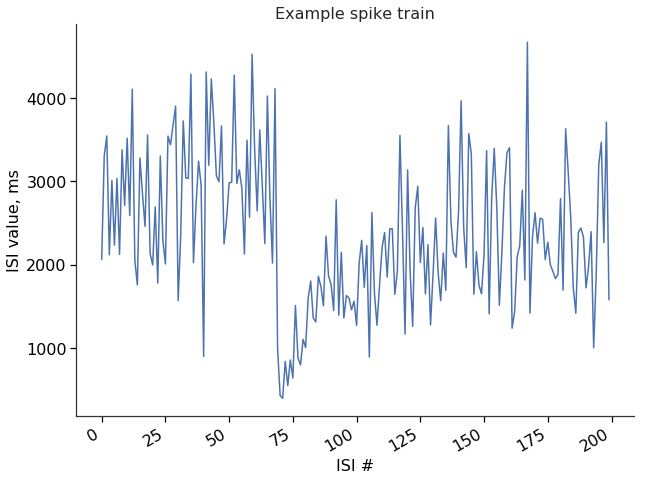

In [23]:
plt.plot(X_train[0, :])
plt.title('Example spike train')
plt.xlabel('ISI #')
plt.ylabel('ISI value, ms')
prettify((15, 8))

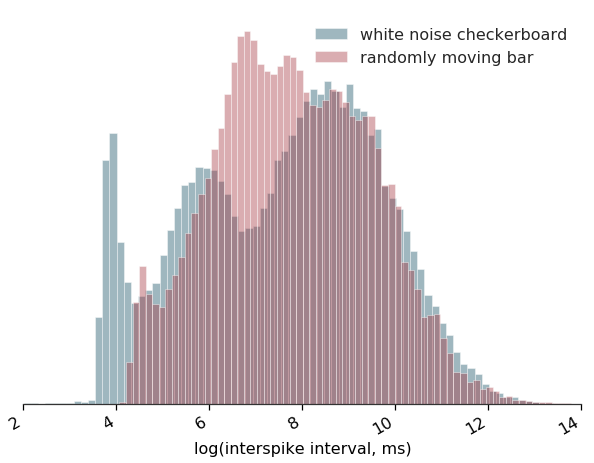

In [32]:
mstate_isis = X_train[y_train == 0, :].flatten()
fstate_isis = X_train[y_train == 1, :].flatten()

ax = plt.axes()
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

eps = 1.0
sns.distplot(np.log(mstate_isis + eps), bins=100, 
             kde=False, norm_hist=True, color=(17/255, 75/255, 95/255));
sns.distplot(np.log(fstate_isis + eps), bins=100, 
             kde=False, norm_hist=True, color=(163/255, 51/255, 61/255));

plt.xlabel('log(interspike interval, ms)')
plt.yticks([])
plt.legend(['white noise checkerboard', 'randomly moving bar'])

plt.xlim(2, 14)

plt.savefig('/disk/neuro/spikebench/main_paper_figs/retina_spikes_histogram.pdf')
plt.savefig('/disk/neuro/spikebench/main_paper_figs/retina_spikes_histogram.eps')

prettify((10, 8))

In [80]:
vectorizer = TsfreshVectorizeTransform(feature_set=config.feature_set)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

Feature Extraction: 100%|██████████| 119/119 [00:51<00:00,  4.58it/s]


In [81]:
preprocessing = TsfreshFeaturePreprocessorPipeline(
        do_scaling=config.scale, 
        remove_low_variance=config.remove_low_variance,
    ).construct_pipeline()
preprocessing.fit(X_train)
X_train = preprocessing.transform(X_train)
X_test = preprocessing.transform(X_test)

In [82]:
print('Dataset size: train {}, test {}'.format(X_train.shape, X_test.shape))
print('Average target: train {}, test {}'.format(y_train.mean(), y_test.mean()))

Dataset size: train (5736, 692), test (5920, 692)
Average target: train 0.7676080892608089, test 0.7782094594594594


In [83]:
num_trials = 10

model = RandomForestClassifier(
    n_estimators=config.n_trees,
    random_state=config.seed,
    max_depth=10,
    n_jobs=-1
)

result_table_columns = ['trial', 'feature_set',
                        'accuracy_test', 'auc_roc_test',
                        'accuracy_train', 'auc_roc_train']
results = {key: [] for key in result_table_columns}
baseline_feature_names = [
    'abs_energy',
    'mean',
    'median',
    'minimum',
    'maximum',
    'standard_deviation',
]
baseline_feature_names = ['value__' + name for name
                            in baseline_feature_names]
metrics_to_collect = {'accuracy': accuracy_score, 'auc_roc': roc_auc_score}

for trial_idx in range(num_trials):
        X_train_sample_balanced, y_train_sample_balanced = simple_undersampling(
            X_train, y_train, subsample_size=config.train_subsample_factor
        )
        X_test_sample_balanced, y_test_sample_balanced = simple_undersampling(
            X_test, y_test, subsample_size=config.test_subsample_factor
        )

        model.fit(X_train_sample_balanced, y_train_sample_balanced)
        for (X, y), dataset_label in [((X_test_sample_balanced, y_test_sample_balanced), 'test'),
                                      ((X_train_sample_balanced, y_train_sample_balanced), 'train')]:
            for metric_name, metric_fn in metrics_to_collect.items():
                model_predictions = model.predict(X) \
                    if metric_name not in ['auc_roc'] else model.predict_proba(X)[:, 1]
                results[metric_name + '_' + dataset_label].append(metric_fn(y, model_predictions))
        results['feature_set'].append(config.feature_set)
        results['trial'].append(trial_idx)

        X_train_sample_balanced = X_train_sample_balanced.loc[:, baseline_feature_names]
        X_test_sample_balanced = X_test_sample_balanced.loc[:, baseline_feature_names]

        model.fit(X_train_sample_balanced, y_train_sample_balanced)

        for (X, y), dataset_label in [((X_test_sample_balanced, y_test_sample_balanced), 'test'),
                                      ((X_train_sample_balanced, y_train_sample_balanced), 'train')]:
            for metric_name, metric_fn in metrics_to_collect.items():
                model_predictions = model.predict(X) \
                    if metric_name not in ['auc_roc'] else model.predict_proba(X)[:, 1]
                results[metric_name + '_' + dataset_label].append(metric_fn(y, model_predictions))

        results['feature_set'].append('simple_baseline')
        results['trial'].append(trial_idx)
    
results = pd.DataFrame(results)

Text(0.5, 1.0, 'Accuracy in stimulus classification task on retinal spike trains\n(random white noise vs. moving bar)')

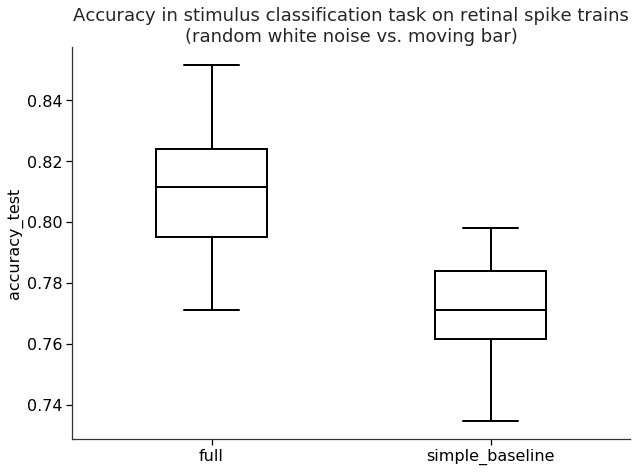

In [84]:
boxplot(x='feature_set', y='accuracy_test', data=results, notch=False)
plt.title('Accuracy in stimulus classification task on retinal spike trains\n'\
          '(random white noise vs. moving bar)', fontsize=18)